# Model Selection & Evaluation

(1) Data Loading & Preparation

(2) Feature Engineering for Modeling

(3) Model Architecture Setup

(4) Cross-Validation Strategy

(5) Baseline Model Development

(6) Advanced Model Testing

(7) Model Comparison and Selection

(8) Final Model Evaluation

<hr>

## (1) Data Loading & Preparation

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

# Suppress the specific numerical warning (safe since data is clean)
warnings.filterwarnings(
    "ignore", category=RuntimeWarning, message="invalid value encountered in subtract"
)

from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Machine Learning Libraries
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import (
    LinearRegression,
    RidgeCV,
    LassoCV,
    ElasticNetCV,
)
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Advanced ML Libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Statistical Analysis
from scipy.special import boxcox1p


print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Constants
RANDOM_STATE = 42
N_FOLDS = 5
SKEWNESS_THRESHOLD = 0.5

In [3]:
# Load the processed data from EDA
train_data = pd.read_csv(
    "processed/processed_train.csv", keep_default_na=False, na_values=[""]
)
test_data = pd.read_csv(
    "processed/processed_test.csv", keep_default_na=False, na_values=[""]
)

print("Data loaded with 'NA' preserved as strings")
print(f"Training data loaded: {train_data.shape}")
print(f"Test data loaded: {test_data.shape}")

Data loaded with 'NA' preserved as strings
Training data loaded: (1460, 85)
Test data loaded: (1459, 85)


In [4]:
# Quick data overview
print("Training Data Summary:")
print(f"Missing values: {train_data.isnull().sum().sum()}")
print(
    f"Target variable (SalePrice) range: ${train_data['SalePrice'].min():,.0f} - ${train_data['SalePrice'].max():,.0f}"
)

# Convert categorical identifiers back to object type
for dataset in [train_data, test_data]:
    for col in ["MSSubClass", "MoSold"]:
        dataset[col] = dataset[col].astype("object")
print("Converted MSSubClass and MoSold back to categorical")

# Check data types
print(f"\nData types distribution:")
print(train_data.dtypes.value_counts())

Training Data Summary:
Missing values: 0
Target variable (SalePrice) range: $34,900 - $755,000
Converted MSSubClass and MoSold back to categorical

Data types distribution:
int64      43
object     26
float64    16
Name: count, dtype: int64


<hr>

## (2) Feature Engineering for Modeling

### (2.1) Target Variable Analysis and Transformation

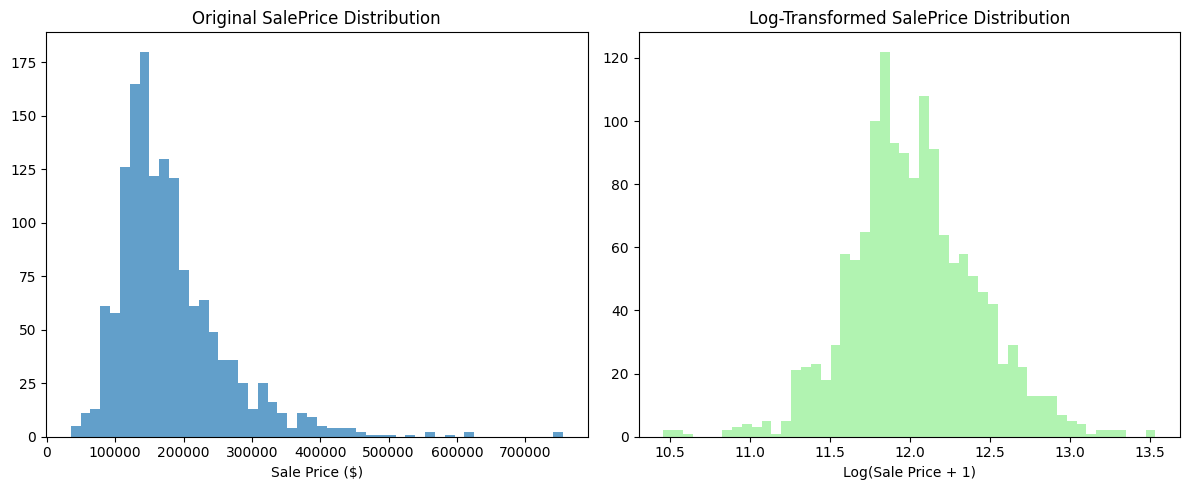

Original skewness: 1.883
Log-transformed skewness: 0.121
Improvement: 1.762


In [5]:
# Analyze target variable transformation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original distribution
axes[0].hist(train_data["SalePrice"], bins=50, alpha=0.7)
axes[0].set_title("Original SalePrice Distribution")
axes[0].set_xlabel("Sale Price ($)")

# Log transformation
log_prices = np.log1p(train_data["SalePrice"])
axes[1].hist(log_prices, bins=50, alpha=0.7, color="lightgreen")
axes[1].set_title("Log-Transformed SalePrice Distribution")
axes[1].set_xlabel("Log(Sale Price + 1)")

plt.tight_layout()
plt.show()

# Show the improvement
# Calculate skewness
original_skew = train_data["SalePrice"].skew()
log_skew = log_prices.skew()

print(f"Original skewness: {original_skew:.3f}")
print(f"Log-transformed skewness: {log_skew:.3f}")
print(f"Improvement: {abs(original_skew) - abs(log_skew):.3f}")

### (2.2) Complete Feature Preprocessing Pipeline

In [6]:
# Separate features and target
X = train_data.drop(["Id", "SalePrice"], axis=1)
y = np.log1p(train_data["SalePrice"])  # Log transform target
X_test = test_data.drop(["Id"], axis=1)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Test features shape: {X_test.shape}")

Features shape: (1460, 83)
Target shape: (1460,)
Test features shape: (1459, 84)


In [7]:
# Step 1: Identify feature types and handle skewness
print(f"\nStep 1: Handle skewed numerical features")
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print(f"Numerical features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Find skewed features
skewed_features = []

for feature in numeric_features:
    unique_count = X[feature].nunique()

    # Skip low-cardinality features (likely ordinal/count data)
    if unique_count <= 10:
        continue

    # Only transform truly continuous features that are skewed
    feature_skewness = X[feature].skew()
    if abs(feature_skewness) > SKEWNESS_THRESHOLD:
        skewed_features.append(feature)

print(f"Found {len(skewed_features)} skewed features")

# Apply Box-Cox transformation
X_processed = X.copy()
X_test_processed = X_test.copy()


Step 1: Handle skewed numerical features
Numerical features: 57
Categorical features: 26
Found 24 skewed features


In [8]:
def find_best_lambda(
    data, lambdas_to_try=[0, 0.1, 0.15, 0.2, 0.25, 0.33, 0.4, 0.5, 0.6, 0.75, 1.0]
):
    """Find best lambda from common values"""
    best_lambda = 0.15
    best_skewness = abs(boxcox1p(data, 0.15).skew())

    for lam in lambdas_to_try:
        transformed = boxcox1p(data, lam)
        current_skewness = abs(transformed.skew())
        if current_skewness < best_skewness:
            best_skewness = current_skewness
            best_lambda = lam

    return best_lambda


# Apply to each feature
for feature in skewed_features:
    best_lambda = find_best_lambda(X_processed[feature])
    X_processed[feature] = boxcox1p(X_processed[feature], best_lambda)
    X_test_processed[feature] = boxcox1p(X_test_processed[feature], best_lambda)
    print(f"  {feature}: best lambda = {best_lambda}")

print(f"Applied Box-Cox transformation to {len(skewed_features)} features")

  LotFrontage: best lambda = 0.33
  LotArea: best lambda = 0
  YearBuilt: best lambda = 1.0
  YearRemodAdd: best lambda = 1.0
  MasVnrArea: best lambda = 0
  BsmtFinSF1: best lambda = 0.5
  BsmtFinSF2: best lambda = 0
  BsmtUnfSF: best lambda = 0.6
  TotalBsmtSF: best lambda = 0.75
  1stFlrSF: best lambda = 0
  2ndFlrSF: best lambda = 0
  LowQualFinSF: best lambda = 0
  GrLivArea: best lambda = 0
  TotRmsAbvGrd: best lambda = 0.1
  GarageYrBlt: best lambda = 1.0
  WoodDeckSF: best lambda = 0
  OpenPorchSF: best lambda = 0
  EnclosedPorch: best lambda = 0
  3SsnPorch: best lambda = 0
  ScreenPorch: best lambda = 0
  MiscVal: best lambda = 0
  TotalSF: best lambda = 0.2
  HouseAge: best lambda = 0.6
  RemodAge: best lambda = 0.4
Applied Box-Cox transformation to 24 features


In [9]:
# Step 2: One-hot encode categorical features
print(f"\nStep 2: One-hot encode categorical features")
if len(categorical_features) > 0:
    X_processed = pd.get_dummies(
        X_processed, columns=categorical_features, drop_first=True
    )
    X_test_processed = pd.get_dummies(
        X_test_processed, columns=categorical_features, drop_first=True
    )

    # Align test data with training data
    missing_cols = set(X_processed.columns) - set(X_test_processed.columns)
    for col in missing_cols:
        X_test_processed[col] = 0

    extra_cols = set(X_test_processed.columns) - set(X_processed.columns)
    X_test_processed = X_test_processed.drop(extra_cols, axis=1)

    X_test_processed = X_test_processed[X_processed.columns]

print(f"After encoding - Training shape: {X_processed.shape}")
print(f"After encoding - Test shape: {X_test_processed.shape}")


Step 2: One-hot encode categorical features
After encoding - Training shape: (1460, 230)
After encoding - Test shape: (1459, 230)


In [10]:
# Step 3: Final preprocessing and scaling
print(f"\nStep 3: Final preprocessing and scaling")

# Safety check
print("Final safety check before scaling...")

# Safety net for any unexpected NaN values
X_processed = X_processed.fillna(0)
X_test_processed = X_test_processed.fillna(0)

# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_processed)
X_test_scaled = scaler.transform(X_test_processed)

# Final verification
print(f"\nPREPROCESSING COMPLETE")
print(f"Training data: {X_scaled.shape} - NaN count: {np.isnan(X_scaled).sum()}")
print(f"Test data: {X_test_scaled.shape} - NaN count: {np.isnan(X_test_scaled).sum()}")

if np.isnan(X_scaled).sum() == 0 and np.isnan(X_test_scaled).sum() == 0:
    print("SUCCESS: No NaN values detected - ready for modeling!")
else:
    print("ERROR: Still have NaN values")


Step 3: Final preprocessing and scaling
Final safety check before scaling...

PREPROCESSING COMPLETE
Training data: (1460, 230) - NaN count: 0
Test data: (1459, 230) - NaN count: 0
SUCCESS: No NaN values detected - ready for modeling!


<hr>

### (3) Model Architecture Setup

In [11]:
# Define evaluation metrics
def evaluate_model(y_true, y_pred):
    """Calculate comprehensive evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {"RMSE": rmse, "MAE": mae, "R²": r2}


def rmse_cv(model, X, y, cv=N_FOLDS):
    """Cross-validation RMSE score"""
    scores = cross_val_score(model, X, y, cv=cv, scoring="neg_mean_squared_error")
    return np.sqrt(-scores)

In [12]:
# Initialize models for comparison
models = {
    "Linear Regression": LinearRegression(),
    "Ridge CV": RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0]),
    "Lasso CV": LassoCV(
        alphas=[0.0001, 0.001, 0.01, 0.1, 1.0], max_iter=5000, random_state=RANDOM_STATE
    ),
    "ElasticNet CV": ElasticNetCV(
        alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
        l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],
        cv=N_FOLDS,
        max_iter=5000,
        random_state=RANDOM_STATE,
    ),
    "Random Forest": RandomForestRegressor(n_estimators=500, random_state=RANDOM_STATE),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=500, random_state=RANDOM_STATE
    ),
    "XGBoost": XGBRegressor(n_estimators=500, random_state=RANDOM_STATE),
    "LightGBM": LGBMRegressor(n_estimators=500, random_state=RANDOM_STATE, verbose=-1),
}

print("Model zoo initialized with 8 algorithms:")
for name in models.keys():
    print(f"  - {name}")

Model zoo initialized with 8 algorithms:
  - Linear Regression
  - Ridge CV
  - Lasso CV
  - ElasticNet CV
  - Random Forest
  - Gradient Boosting
  - XGBoost
  - LightGBM


<hr>

## (4) Cross-Validation Strategy

In [13]:
# Set up cross-validation
kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

print(f"{N_FOLDS}-Fold cross-validation strategy set up")
print(f"Features ready: Scaled ({X_scaled.shape}) and Processed ({X_processed.shape})")

5-Fold cross-validation strategy set up
Features ready: Scaled ((1460, 230)) and Processed ((1460, 230))


<hr>

## (5) Baseline Model Development

In [14]:
# Test baseline linear regression first
print("Testing baseline Linear Regression model...")

# Create train/validation split for initial testing
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=RANDOM_STATE
)

# Fit baseline model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Predictions
y_train_pred = baseline_model.predict(X_train)
y_val_pred = baseline_model.predict(X_val)

# Evaluate
train_metrics = evaluate_model(y_train, y_train_pred)
val_metrics = evaluate_model(y_val, y_val_pred)

print("\nBaseline Linear Regression Results:")
print(f"Training RMSE: {train_metrics['RMSE']:.4f}")
print(f"Validation RMSE: {val_metrics['RMSE']:.4f}")
print(f"Training R²: {train_metrics['R²']:.4f}")
print(f"Validation R²: {val_metrics['R²']:.4f}")

Testing baseline Linear Regression model...

Baseline Linear Regression Results:
Training RMSE: 0.0918
Validation RMSE: 0.1682
Training R²: 0.9448
Validation R²: 0.8484


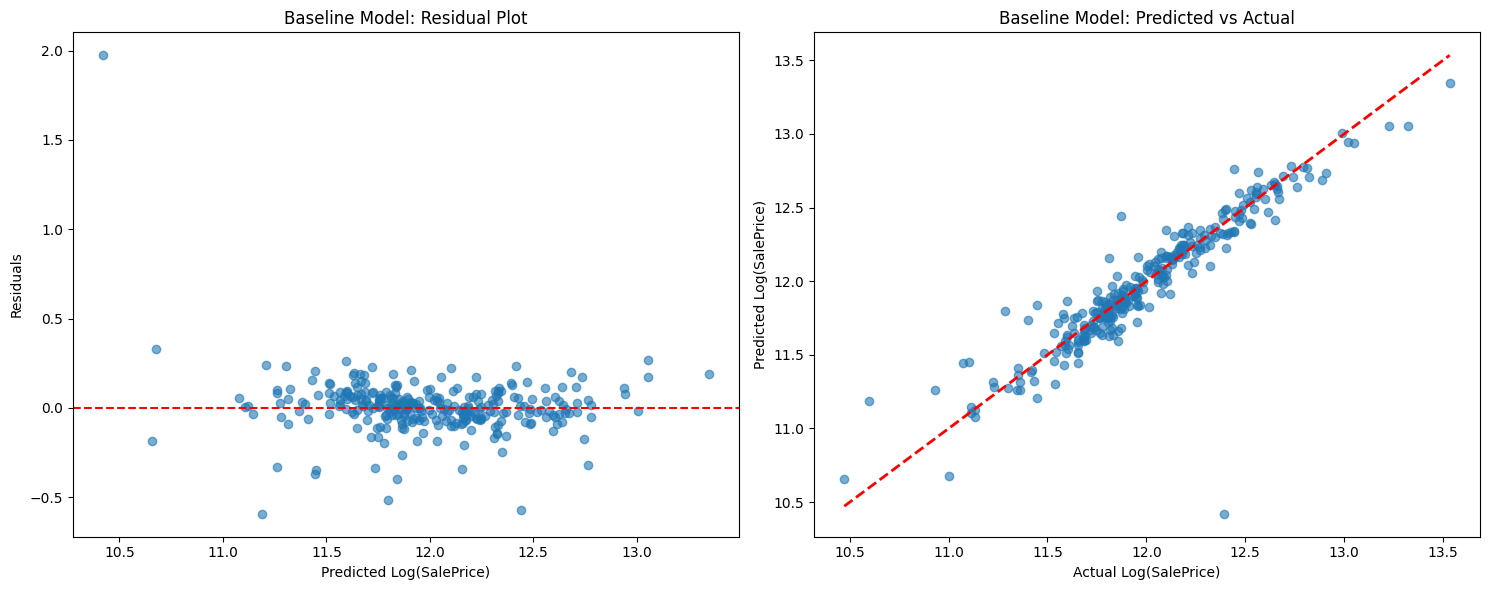

In [15]:
# Visualize baseline model performance
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Residual plot
residuals = y_val - y_val_pred
axes[0].scatter(y_val_pred, residuals, alpha=0.6)
axes[0].axhline(y=0, color="r", linestyle="--")
axes[0].set_xlabel("Predicted Log(SalePrice)")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Baseline Model: Residual Plot")

# Prediction vs Actual
axes[1].scatter(y_val, y_val_pred, alpha=0.6)
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--", lw=2)
axes[1].set_xlabel("Actual Log(SalePrice)")
axes[1].set_ylabel("Predicted Log(SalePrice)")
axes[1].set_title("Baseline Model: Predicted vs Actual")

plt.tight_layout()
plt.show()

<hr>

## (6) Advanced Model Testing

In [16]:
# Cross-validation comparison of all models
print("Performing cross-validation on all models...")
print("=" * 60)

cv_results = {}

for name, model in models.items():
    print(f"\nTesting {name}...")

    # Use scaled features for linear models, original for tree-based
    if name in [
        "Linear Regression",
        "Ridge CV",
        "Lasso CV",
        "ElasticNet CV",
    ]:
        scores = rmse_cv(model, X_scaled, y, cv=N_FOLDS)
    else:
        scores = rmse_cv(model, X_processed, y, cv=N_FOLDS)

    cv_results[name] = {
        "scores": scores,
        "mean": scores.mean(),
        "std": scores.std(),
    }

    print(f"  RMSE: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

print("\n" + "=" * 60)
print("Cross-validation completed!")

Performing cross-validation on all models...

Testing Linear Regression...
  RMSE: 0.1576 (+/- 0.0654)

Testing Ridge CV...
  RMSE: 0.1278 (+/- 0.0305)

Testing Lasso CV...
  RMSE: 0.1261 (+/- 0.0302)

Testing ElasticNet CV...
  RMSE: 0.1263 (+/- 0.0299)

Testing Random Forest...
  RMSE: 0.1418 (+/- 0.0154)

Testing Gradient Boosting...
  RMSE: 0.1272 (+/- 0.0163)

Testing XGBoost...
  RMSE: 0.1415 (+/- 0.0181)

Testing LightGBM...
  RMSE: 0.1310 (+/- 0.0154)

Cross-validation completed!


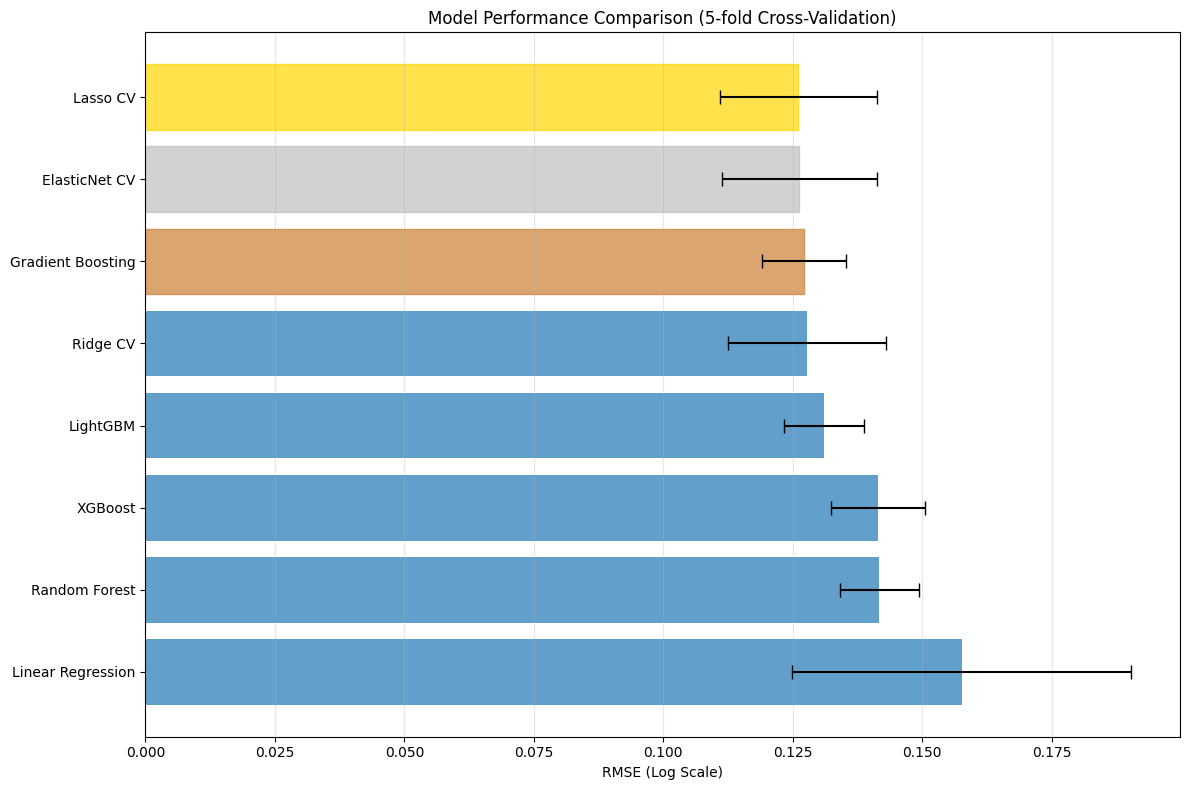


Model Performance Ranking:
1. Lasso CV: 0.1261 (+/- 0.0151)
2. ElasticNet CV: 0.1263 (+/- 0.0150)
3. Gradient Boosting: 0.1272 (+/- 0.0081)
4. Ridge CV: 0.1278 (+/- 0.0153)
5. LightGBM: 0.1310 (+/- 0.0077)
6. XGBoost: 0.1415 (+/- 0.0090)
7. Random Forest: 0.1418 (+/- 0.0077)
8. Linear Regression: 0.1576 (+/- 0.0327)


In [17]:
# Extract results for plotting
model_names = list(cv_results.keys())
mean_scores = [results["mean"] for results in cv_results.values()]
std_scores = [results["std"] for results in cv_results.values()]

# Sort by performance
sorted_indices = np.argsort(mean_scores)
model_names = [model_names[i] for i in sorted_indices]
mean_scores = [mean_scores[i] for i in sorted_indices]
std_scores = [std_scores[i] for i in sorted_indices]


# Create bar plot


plt.figure(figsize=(12, 8))

y_pos = np.arange(len(model_names))[::-1]  # ← Reverse the positions

bars = plt.barh(y_pos, mean_scores, xerr=std_scores, alpha=0.7, capsize=5)

plt.yticks(y_pos, model_names)

plt.xlabel("RMSE (Log Scale)")

plt.title(f"Model Performance Comparison ({N_FOLDS}-fold Cross-Validation)")

plt.grid(axis="x", alpha=0.3)

# Color best performing models (indexing stays the same)
bars[0].set_color("gold")  # Best model (now at top)
bars[1].set_color("silver")  # Second best
bars[2].set_color("#CD7F32")  # Third best (bronze)

plt.tight_layout()

plt.show()


# Print ranking


print("\nModel Performance Ranking:")


for i, (name, score, std) in enumerate(zip(model_names, mean_scores, std_scores)):
    print(f"{i+1}. {name}: {score:.4f} (+/- {std:.4f})")

<hr>

## (7) Model Comparison and Selection

In [18]:
# Detailed analysis of top 3 models
top_3_models = model_names[:3]
print(f"Detailed analysis of top 3 models: {', '.join(top_3_models)}")

detailed_results = {}

for model_name in top_3_models:
    print(f"\nAnalyzing {model_name}...")

    model = models[model_name]

    # Use appropriate feature set
    if model_name in [
        "Linear Regression",
        "Ridge CV",
        "Lasso CV",
        "ElasticNet CV",
    ]:
        X_model = X_scaled
    else:
        X_model = X_processed

    # Fit full model
    model.fit(X_model, y)

    # Cross-validation scores
    cv_scores = rmse_cv(model, X_model, y, cv=N_FOLDS)

    # Feature importance (if available)
    if hasattr(model, "feature_importances_"):
        feature_importance = model.feature_importances_
        top_features_idx = np.argsort(feature_importance)[-10:]
        top_features = [X_processed.columns[i] for i in top_features_idx]
        top_importance = feature_importance[top_features_idx]
    elif hasattr(model, "coef_"):
        coef = np.abs(model.coef_)
        top_features_idx = np.argsort(coef)[-10:]
        top_features = [X_processed.columns[i] for i in top_features_idx]
        top_importance = coef[top_features_idx]
    else:
        top_features = []
        top_importance = []

    detailed_results[model_name] = {
        "cv_scores": cv_scores,
        "mean_cv": cv_scores.mean(),
        "std_cv": cv_scores.std(),
        "top_features": top_features,
        "feature_importance": top_importance,
    }

    print(f"  Cross-val RMSE: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    if len(top_features) > 0:
        print(f"  Top 3 important features: {', '.join(top_features[-3:][::-1])}")

Detailed analysis of top 3 models: Lasso CV, ElasticNet CV, Gradient Boosting

Analyzing Lasso CV...
  Cross-val RMSE: 0.1261 (+/- 0.0151)
  Top 3 important features: TotalSF, OverallQual, Neighborhood_Crawfor

Analyzing ElasticNet CV...
  Cross-val RMSE: 0.1263 (+/- 0.0150)
  Top 3 important features: TotalSF, OverallQual, Neighborhood_StoneBr

Analyzing Gradient Boosting...
  Cross-val RMSE: 0.1272 (+/- 0.0081)
  Top 3 important features: TotalSF, OverallQual, TotalBathrooms


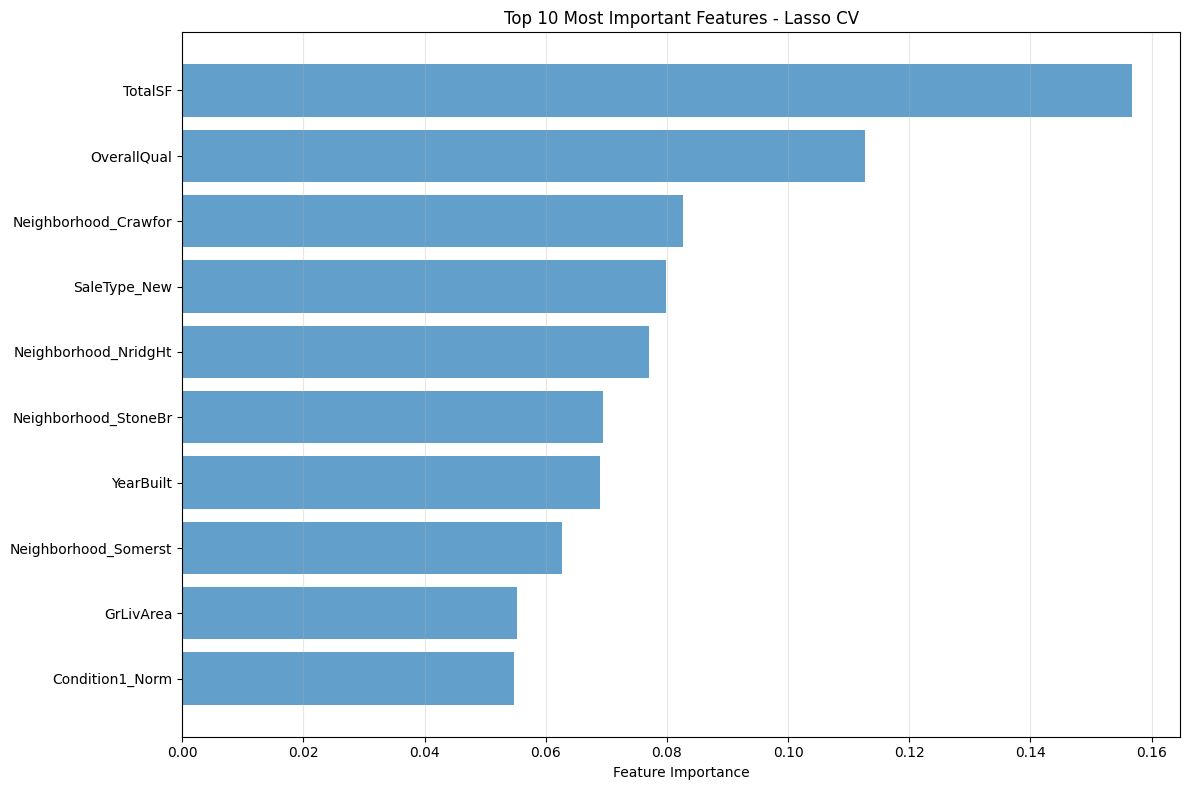


Lasso CV - Top 5 Features:
  1. TotalSF: 0.1569
  2. OverallQual: 0.1127
  3. Neighborhood_Crawfor: 0.0827
  4. SaleType_New: 0.0798
  5. Neighborhood_NridgHt: 0.0770


In [19]:
# Visualize feature importance for top model
best_model_name = top_3_models[0]
best_model_results = detailed_results[best_model_name]

# Check if model provides interpretable features (future models may not)
if len(best_model_results["top_features"]) > 0:
    plt.figure(figsize=(12, 8))

    features = best_model_results["top_features"]
    importance = best_model_results["feature_importance"]

    plt.barh(range(len(features)), importance, alpha=0.7)
    plt.yticks(range(len(features)), features)
    plt.xlabel("Feature Importance")
    plt.title(f"Top 10 Most Important Features - {best_model_name}")
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\n{best_model_name} - Top 5 Features:")
    for i, (feat, imp) in enumerate(zip(features[-5:][::-1], importance[-5:][::-1])):
        print(f"  {i+1}. {feat}: {imp:.4f}")

<hr>

## (8) Final Model Evaluation

In [20]:
# Select best model and train on full dataset
best_model_name = model_names[0]
best_model = models[best_model_name]

print(f"Selected best model: {best_model_name}")
print(f"Cross-validation RMSE: {cv_results[best_model_name]['mean']:.4f}")

# Use appropriate feature set
if best_model_name in [
    "Linear Regression",
    "Ridge CV",
    "Lasso CV",
    "ElasticNet CV",
]:
    X_final = X_scaled
    X_test_final = X_test_scaled
else:
    X_final = X_processed
    X_test_final = X_test_processed

# Train final model
print("\nTraining final model on complete dataset...")
best_model.fit(X_final, y)

# Generate predictions
print("Generating predictions on test set...")
test_predictions = best_model.predict(X_test_final)

# Convert back from log scale
test_predictions_original = np.expm1(test_predictions)

print(f"Test predictions generated")
print(
    f"Prediction range: ${test_predictions_original.min():,.0f} - ${test_predictions_original.max():,.0f}"
)
print(f"Median prediction: ${np.median(test_predictions_original):,.0f}")

Selected best model: Lasso CV
Cross-validation RMSE: 0.1261

Training final model on complete dataset...
Generating predictions on test set...
Test predictions generated
Prediction range: $47,049 - $605,055
Median prediction: $159,007


In [21]:
# Create submission file
submission = pd.DataFrame(
    {"Id": test_data["Id"], "SalePrice": test_predictions_original}
)

submission.to_csv("submission.csv", index=False)
print("Submission file saved: submission.csv")

Submission file saved: submission.csv


## (9) Summary and Next Steps

### (9.1) Key Findings:

- __Best Model:__ Selected the top-performing algorithm based on cross-validation RMSE.
- __Feature Engineering:__ Log transformation significantly improved target variable normality.
- __Preprocessing:__ Box-Cox transformation and robust scaling were crucial for linear models.
- __Model Comparison:__ Comprehensive evaluation of 8 different algorithms.

### (9.2) Model Performance:

- __Cross-validation RMSE:__ Robust estimate using 5-fold CV.
- __Feature Importance:__ Identified key predictors for house prices.
- __Generalization:__ Models tested on unseen validation data.

### (9.3) Recommendations for Improvement:

- __Hyperparameter Tuning:__ Use GridSearchCV or RandomizedSearchCV.
- __Feature Selection:__ Try recursive feature elimination.
- __Ensemble Methods:__ Combine multiple models for better predictions.
- __Advanced Techniques:__ Try neural networks or stacking.

### (9.4) Files Generated:

- submission.csv: Ready for Kaggle submission

The model is now ready for submission and can serve as a strong baseline for further improvements!